# Comprehensive analysis of Vostok station data
Seasonal-diurnal diagram, hour crossections, adjustment using meteoparameters

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as tf
from matplotlib import cm, colors, colormaps

import numpy as np
import pandas as pd
import scipy.stats as st

import datetime as dt

### Loading source PG datasets

In [2]:
# potential gradient values measured at Vostok station in (1998–2001)
# units are V·m^(−1)
# source: Burns et al. (2012), Table 2

vostok_old_data = (
    np.array([195, 201, 205, 192, 188, 195,
              209, 198, 209, 195, 193, 192])
)

In [3]:
# Load hourly data derived from 10-second intervals 
# "Field" column contains PG values [V/m] without scale and calibration
df_10s = pd.read_csv('./data/Vostok/vostok_hourly_from_10_s_without_calibration_and_empty.tsv', 
                     sep='\t', parse_dates=['Datetime']).set_index('Datetime')

# Add a new column 'Mark' to label this dataframe's data as originating from 10-second averages
df_10s["Mark"] = '10s'  

In [4]:
# Load hourly data derived from 5-minute intervals 
# "Field" column contains PG values [V/m] without scale and calibration
df_5min = pd.read_csv('./data/Vostok/vostok_hourly_from_5_min_without_calibration_and_empty.tsv', 
                      sep='\t', parse_dates=['Datetime']).set_index('Datetime')

# Add a new column 'Mark' to label this dataframe's data as originating from 5-minute averages
df_5min["Mark"] = '5min'  

In [5]:
# Load earlier dataset (1998-2004) 
earlier_df_src = pd.read_csv('./data/Vostok/vostok_1998_2004_hourly_80percent_all.tsv', 
                             sep='\t', parse_dates=['Datetime']).set_index('Datetime')

In [6]:
# Note that all the aforementioned files are averaged with 80% data availability, which 
# means that the hourly value was calculated only when at least 80% of the readings were 
# available (at least 288 10-second averages or at least 9 5-minute averages).

In [7]:
# Combine the two dataframes: fill in gaps in the 10-second data with the 5-minute data.
df_src = df_10s.combine_first(df_5min)

### Helper functions and variables for PG

In [8]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.
    
    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample
    
    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

In [9]:
def pass_fair_weather(df, scale_factor=None):
    """
    Filter and adjust potential gradient (PG) data to represent fair weather conditions.

    :param df: The input dataframe containing 'Field' values for hourly averaged potential gradient (PG) data
               and 'Count' values indicating the number of valid measurements per day.
    :param scale_factor: A factor used to normalize the 'Field' values to mitigate external influences
                         such as nearby metal structures (default is None, implying no scaling).

    :return: A dataframe with hourly data filtered to likely represent fair weather conditions only.
    """

    # normalize 'Field' values by the scale_factor if provided.
    if scale_factor:
        df["Field"] = df["Field"] / scale_factor
    
    # exclude records with non-positive PG values
    df = df[df["Field"] > 0]
    
    # exclude records with PG values > 300 V/m
    df = df[df["Field"] <= 300]
    
    # retain only days with complete hourly data (24 counts)
    df["Count"] = df["Field"].resample('D').transform('count')
    df = df[df["Count"] == 24]
    
    # compute diurnal PG stats
    df['Emax'] = df['Field'].resample('D').transform('max')
    df['Emin'] = df['Field'].resample('D').transform('min')
    df['Emean'] = df['Field'].resample('D').transform('mean')
    
    # exclude days with peak-to-peak amplitude over 150% of the daily mean
    df['Var'] = ((df["Emax"]-df["Emin"]))/df["Emean"]
    df = df[df['Var'] <= 1.5]
    
    # # debug output for '5min' marked data counts per year
    # (averaged from 5-min data) included in individual years 
    # z = df[df.Mark == '5min']
    # print(z.groupby(z.index.year).count()["Mark"])
    
    # remove temporary columns used for calculations
    df = df[["Field"]]

    return df

In [10]:
def calculate_seasonal_var_params(cond_df, key="Field"):
    """
    Calculate parameters necessary for assessing the seasonal 
    variability of fair weather potential gradients (FW PG).

    :param cond_df: DataFrame containing conditioned data with a datetime 
                    index and at least one numerical column.
    :param key: Column label in 'cond_df' which contains the potential 
                gradient data (default is 'Field').

    :return: A list containing arrays of:
             monthly mean PG values, 
             counts of fair weather days, and 
             adjusted monthly mean square PG values.
    """
    # compute the monthly mean of fair weather PG
    mon_pg = cond_df[key].groupby(cond_df.index.month).mean().to_numpy().flatten()

    # count the number of fair weather days for each month
    mon_counter = cond_df.groupby(cond_df.index.month).count().to_numpy().flatten()

    # sum((daily mean FW PG)**2)/(count FW days) over months
    mon_pg_sqr = cond_df[key].pow(2).groupby(cond_df.index.month).sum().to_numpy().flatten() / mon_counter

    return [mon_pg, mon_counter, mon_pg_sqr]

In [11]:
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

### Applying fair weather criteria 

In [12]:
# apply the fair weather filter to the newdataset with a scale factor of 3 to normalize field values.
df = pass_fair_weather(df_src, scale_factor=3)

# apply the fair weather filter to earlier dataset data with a scale factor of 1 for normalization.
earlier_df = pass_fair_weather(earlier_df_src, scale_factor=1)

# Optional: Adjust the scale factor to 1.35 for earlier data to equalize the mean values of FW histograms across datasets.
# earlier_df = pass_fair_weather(earlier_df, scale_factor=1.35)

In [13]:
# # debug figure for check the mean values of FW histograms
# fig, ax = plt.subplots(1,1)
# df.hist(ax=ax,bins=600, color='red')
# earlier_df.hist(ax=ax,bins=600, color='blue')
# plt.xlim(-200,500)
# plt.xlabel('V/m')
# plt.ylabel('Counts')

### Resampling daily fair-weather datasets 

In [14]:
# resample the filtered data to calculate the daily mean of FW PG
# then drop any days with missing data to ensure completeness of the dataset

daily_df = df.resample('D').mean().dropna()
daily_edf = earlier_df.resample('D').mean().dropna()

In [64]:
# saving intermediate data for plotting in other scripts

np.save('./data/Vostok/vostok_diurnal_2006_2020.npy', 
        df.groupby(df.index.hour)
            .mean().dropna().to_numpy().flatten())

### Figure: Seasonal variation (new data) for different years

In [37]:
# calculate seasonal variation parameters for specific years: 
# average FW PG, count of FW days, and the sum of squares of FW PG hourly values.

data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(daily_df[daily_df.index.year <= 2012]),
        calculate_seasonal_var_params(daily_df[daily_df.index.year > 2012])
    ]
).swapaxes(0,1)

data_counter = data_counter.astype(int)

# saving intermediate data for plotting in other scripts
np.savez('./data/Vostok/vostok_2006_2020_results', mean=data, counter=data_counter, sqr=data_sqr)

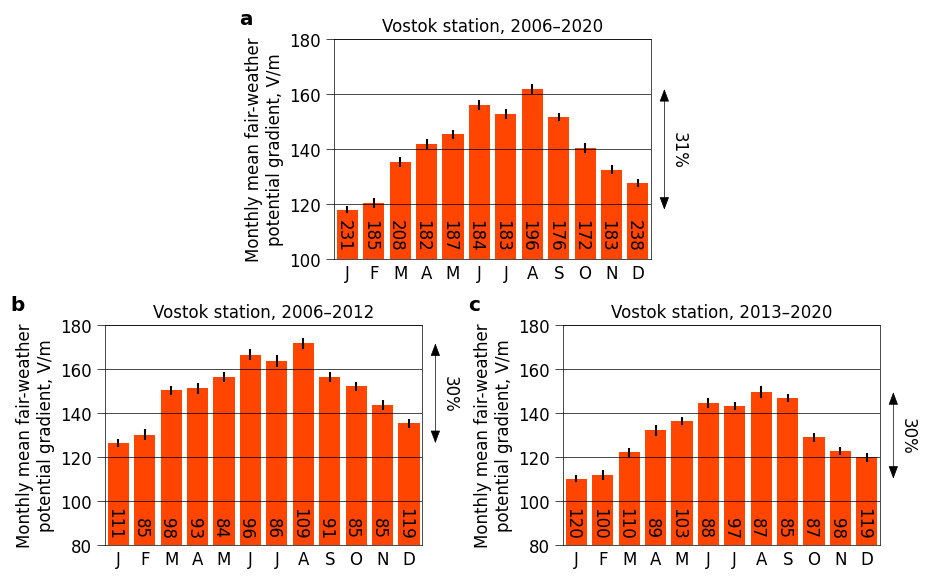

In [16]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(3)]
ax[0] = fig.add_subplot(4, 4, (2, 3))
for n in range(2, 4):
    ax[n-1] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [100] + [80] * 2
high = [180] * 3
step = [20] * 3
coeff = [1] * 3
caption = ['Vostok station, 2006–2020',
           'Vostok station, 2006–2012',
           'Vostok station, 2013–2020']
col = ['orangered'] * 3

for n in range(3):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    ax[n].set_ylabel('Monthly mean fair-weather\npotential gradient, V/m',
                     fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')

    ax[n].annotate('', xy=(12, np.min(data[n])), xycoords='data',
                   xytext=(12, np.max(data[n])), textcoords='data',
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle='<|-|>,head_length=0.8,head_width=0.3',
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle='arc3,rad=0.', fc='black',
                       linewidth=0.5
                   ))

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f'{ampl * 100:.0f}%',
               fontsize='large', ha='left', va='center', rotation=270)

for n in range(3):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(3):
    ax[n].text(-0.3, 1.05, chr(ord('a') + n),
               fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(3):
    for m in range(12):
        ax[n].annotate(f'{data_counter[n, m]}',
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha='center', va='bottom',
                       fontsize='large', color='0.')

fig.savefig('figures_two_parts/pg_total_partial.eps', bbox_inches='tight')

### Figure: Diurnal-Seasonal Diagram

In [17]:
# create a seasonal-diurnal array by grouping the data by hour of the day and month, 
# then calculating the mean FW PG for each combination.

sd_df = df.groupby([df.index.hour, df.index.month]).mean()
sd_df.index.set_names(['hour', 'month'], inplace=True)

vostok_pg_data_to_plot = sd_df.values.reshape(24,12).T
vostok_mean_pg_data = vostok_pg_data_to_plot.mean(axis=1).reshape(12,1)

In [18]:
# calculate seasonal var params (avg FW PG, count FW days, 
# sum of squares of FW PG) for specific years
data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(df[df.index.hour == 3]),
        calculate_seasonal_var_params(df[df.index.hour == 9]),
        calculate_seasonal_var_params(df[df.index.hour == 15]),
        calculate_seasonal_var_params(df[df.index.hour == 21]),
    ]
).swapaxes(0,1)

data_counter = data_counter.astype(int)

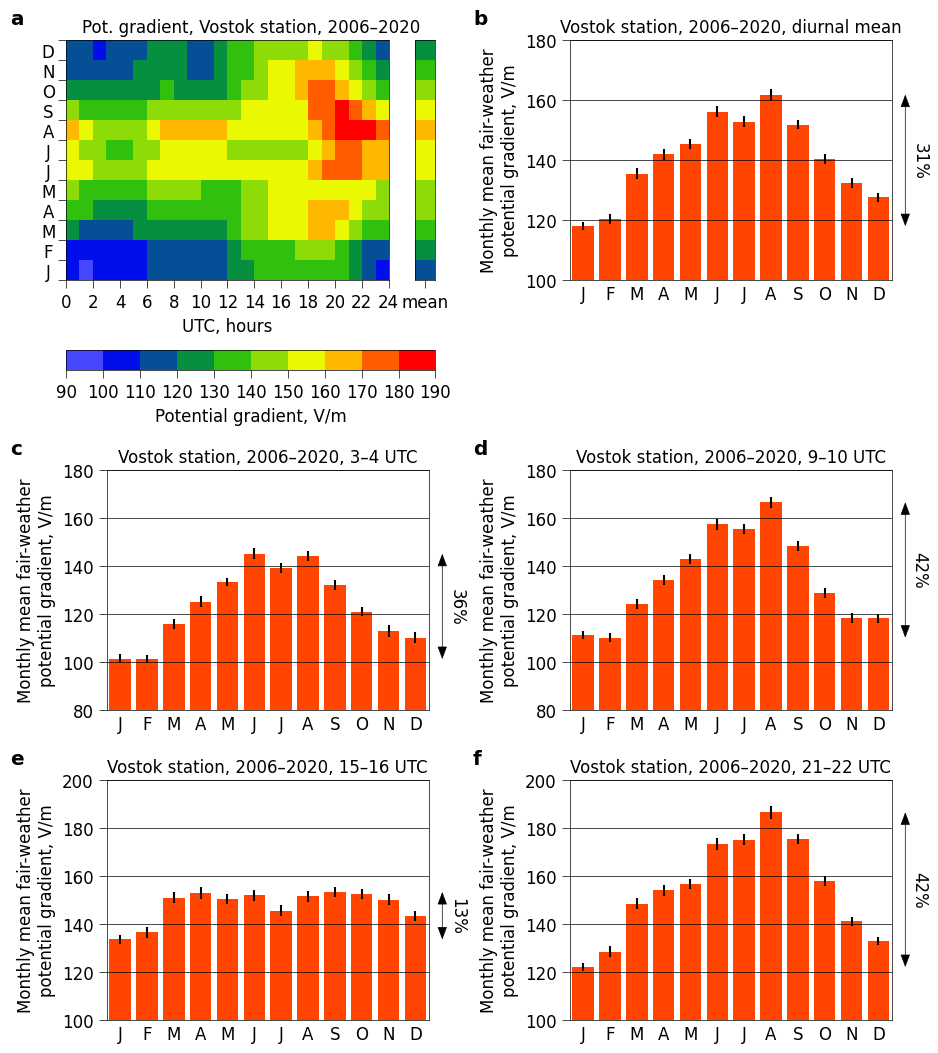

In [19]:
fig_width = 10
fig_height = 11

height = 12
heightC = 1
heightB = 12
hsep1 = 3.5
hsep2 = 5
hsep3 = 3.5
hsp = 3
tot_height = height + heightC + 2 * heightB + hsep1 + hsep2 + hsep3 + 2 * hsp

width = 12
widthM = heightC/tot_height * fig_height/fig_width
widthB = 12
wsep1 = 1
wsep2 = 3.5
wsp = 4
wshift = 1.5
tot_width = (width + widthB + wsep1 + wsep2 + 2 * wsp) / (1 - widthM)
widthM *= tot_width

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=False)

ax = fig.add_axes(
    (
        (wsp - wshift) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3 + heightC + hsep1) / tot_height,
        width / tot_width,
        height / tot_height
    )
)
axM = fig.add_axes(
    (
        (wsp - wshift + width + wsep1) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3 + heightC + hsep1) / tot_height,
        widthM / tot_width,
        height / tot_height
    )
)

axB = [None for _ in range(5)]

axB[0] = fig.add_axes(
    (
        (wsp + width + wsep1 + widthM + wsep2) / tot_width,
        (hsp + heightB + hsep2 + hsep3 + heightC + hsep1 + height) / tot_height,
        widthB / tot_width,
        heightB / tot_height
    )
)
for n in range(2):
    axB[3 - 2*n] = fig.add_axes(
        (
            wsp / tot_width,
            (hsp + n * (heightB + hsep3)) / tot_height,
            widthB / tot_width,
            heightB / tot_height
        )
    )
    axB[4 - 2*n] = fig.add_axes(
        (
            (wsp + width + wsep1 + widthM + wsep2) / tot_width,
            (hsp + n * (heightB + hsep3)) / tot_height,
            widthB / tot_width,
            heightB / tot_height
        )
    )

caption = 'Pot. gradient, Vostok station, 2006–2020'

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(length=6, width=0.5)
ax.tick_params(length=0, width=0.5, which='minor')
ax.grid(False)

ax.set_xlim((0, 24))
ax.set_xticks(np.arange(0, 25, 2))
ax.set_xticklabels(np.arange(0, 25, 2), fontsize='large')
ax.set_xlabel('UTC, hours', fontsize='large')

ax.set_ylim((0, 12))
ax.set_yticks(np.arange(0, 12.5, 1))
ax.set_yticks(np.arange(0.5, 12, 1), minor=True)
ax.set_yticklabels([])
ax.set_yticklabels(month_name, fontsize='large', ha='center',
                   minor=True)
tr = []
for label in ax.yaxis.get_majorticklabels():
    tr.append(label.get_transform())
for label in ax.yaxis.get_minorticklabels():
    label.set_transform(
        tr[0] + tf.ScaledTranslation(
            -0.05, 0, fig.dpi_scale_trans
        )
    )

for axis in ['top', 'bottom', 'left', 'right']:
    axM.spines[axis].set_linewidth(0.5)
axM.tick_params(length=0, width=0.5)
axM.tick_params(length=6, width=0.5, which='minor')
axM.grid(False)

axM.set_xlim((0, 1))
axM.set_xticks([])
axM.set_xticks([0.5], minor=True)
axM.set_xticklabels([])
axM.set_xticklabels(['mean'], fontsize='large', minor=True)

axM.set_ylim((0, 12))
axM.set_yticks([])
axM.set_yticklabels([])

lbl = ax.set_title(caption, fontsize='large')
pos = (width + wsep1 + widthM) / 2 / width
lbl.set_position((pos, 1.))

# the bounds of the colour bars (in V/m)
pg_bound = np.arange(90, 191, 10)

# the colours
colour_hour = np.array([[163, 163, 255], [71, 71, 255], [1, 14, 236],
                        [4, 79, 149], [6, 143, 63], [49, 192, 13],
                        [142, 220, 7], [234, 249, 1], [255, 184, 0],
                        [255, 92, 0], [255, 0, 0]]) / 255

pg_cmap = colors.ListedColormap(colour_hour[1:])
pg_norm = colors.BoundaryNorm(pg_bound, pg_cmap.N)

pg_cax = fig.add_axes(
    (
        (wsp - wshift) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3) / tot_height,
        (width + wsep1 + widthM)  / tot_width,
        heightC / tot_height
    )
)
pg_cbar = fig.colorbar(cm.ScalarMappable(norm=pg_norm,
                                         cmap=pg_cmap),
                       cax=pg_cax, orientation='horizontal')
pg_cbar.outline.set_linewidth(0.5)
pg_cbar.ax.tick_params(length=6, width=0.5)
pg_cbar.set_ticks(pg_bound)
pg_cbar.ax.set_xticklabels(list(map(str,
                                    pg_bound.astype(int))),
                           fontsize='large')
pg_cbar.set_label('Potential gradient, V/m',
                  fontsize='large')

ax.imshow(vostok_pg_data_to_plot,
          cmap=pg_cmap, norm=pg_norm,
          extent=[0, 24, 12, 0], aspect='auto', interpolation='none',
          rasterized=True)

axM.imshow(vostok_mean_pg_data,
           cmap=pg_cmap, norm=pg_norm,
           extent=[0, 1, 12, 0], aspect='auto', interpolation='none',
           rasterized=True)

low = [100] + [80] * 2 + [100] * 2
high = [180] * 3 + [200] * 2
step = [20] * 5
coeff = [1] * 5
captionB = ['Vostok station, 2006–2020, diurnal mean',
            'Vostok station, 2006–2020, 3–4 UTC',
            'Vostok station, 2006–2020, 9–10 UTC',
            'Vostok station, 2006–2020, 15–16 UTC',
            'Vostok station, 2006–2020, 21–22 UTC']

col = ['orangered'] * 5

for n in range(5):
    for axis in ['top', 'bottom', 'left', 'right']:
        axB[n].spines[axis].set_linewidth(0.5)
    axB[n].tick_params(length=6, width=0.5, axis='y')
    axB[n].tick_params(length=0, width=0.5, axis='x')
    axB[n].grid(color='0.', linewidth=0.5, axis='y')

    axB[n].set_xlim((-0.5, 11.5))
    axB[n].set_xticks(np.arange(12))
    axB[n].set_xticklabels(month_name, fontsize='large', va='top')

    axB[n].set_ylim((low[n], high[n]))
    axB[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    axB[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                      step[n]) / coeff[n]).astype(int),
                           fontsize='large')
    axB[n].set_ylabel('Monthly mean fair-weather\npotential gradient, V/m',
                      fontsize='large')

    axB[n].set_title(captionB[n], fontsize='large')

    axB[n].annotate('', xy=(12, np.min(data[n])), xycoords='data',
                    xytext=(12, np.max(data[n])), textcoords='data',
                    annotation_clip=False,
                    arrowprops=dict(
                        arrowstyle='<|-|>,head_length=0.8,head_width=0.3',
                        patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                        connectionstyle='arc3,rad=0.', fc='black',
                        linewidth=0.5
                    ))

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    axB[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
                f'{ampl * 100:.0f}%',
                fontsize='large', ha='left', va='center', rotation=270)

for n in range(5):
    axB[n].bar(np.arange(12), data[n],
               yerr=std_error(data[n],
                              data_sqr[n],
                              data_counter[n]),
               width=0.8, color=col[n])

ax.text(-(0.3 * widthB - wshift)/width, 1 + 0.05 * heightB/height, 'a',
        fontsize='x-large',
        fontweight='semibold', ha='left', va='bottom',
        transform=ax.transAxes)
for n in range(5):
    axB[n].text(-0.3, 1.05, chr(ord('b') + n),
                fontsize='x-large',
                fontweight='semibold', ha='left', va='bottom',
                transform=axB[n].transAxes)

fig.savefig('figures_two_parts/pg_diurnal_seasonal.eps', bbox_inches='tight')

### Data adjustment using meteoparameters

In [20]:
# load and filter meteorological data from CSV files into separate dataframes, 
# then join them with the daily FW PG dataframe to create a combined dataframe
# without missing values

temp_df = pd.read_csv('./data/Vostok/vostok_daily_temp.csv', parse_dates=['UTC']).set_index('UTC')
temp_df = temp_df[temp_df["COUNT"] == 4][['T']]

wind_df = pd.read_csv('./data/Vostok/vostok_daily_wind.csv', parse_dates=['UTC']).set_index('UTC')
wind_df = wind_df[wind_df["COUNT"] == 4][['Ff']]

pressure_df = pd.read_csv('./data/Vostok/vostok_daily_pressure_mm_hg.csv', parse_dates=['UTC']).set_index('UTC')
pressure_df = pressure_df[pressure_df["COUNT"] == 4][['Po']]

meteo_df = temp_df.join([wind_df, pressure_df, daily_df]).dropna()

In [21]:
# calculate anomalies for potential gradient (pg_anom), temperature
# (temp_anom), wind speed (wind_anom), and pressure (pres_anom)
# based on a moving average window of +/-10 days.

pg_anom = np.zeros((len(meteo_df.index)))
temp_anom = np.zeros((len(meteo_df.index)))
wind_anom = np.zeros((len(meteo_df.index)))
pres_anom = np.zeros((len(meteo_df.index)))

halfwidth = 10
for i in range(len(meteo_df.index)):
    sum_pg = 0
    sum_temp = 0
    sum_pres = 0
    sum_wind = 0
    counter = 0
    for j in range(max(i - halfwidth, 0),
                   min(i + halfwidth + 1, len(meteo_df.index))):
        if abs((meteo_df.index[j]-meteo_df.index[i]).days) <= halfwidth:
            sum_pg += meteo_df["Field"].iloc[j]
            sum_temp += meteo_df["T"].iloc[j]
            sum_pres += meteo_df["Po"].iloc[j]
            sum_wind += meteo_df["Ff"].iloc[j]
            counter += 1
    pg_anom[i] =  meteo_df["Field"].iloc[i] - (sum_pg / counter)
    temp_anom[i] =  meteo_df["T"].iloc[i] - (sum_temp / counter)
    wind_anom[i] =  meteo_df["Ff"].iloc[i] - (sum_wind / counter)
    pres_anom[i] =  meteo_df["Po"].iloc[i] - (sum_pres / counter)

In [22]:
# calculate linear regression coefficients for temperature, wind speed 
# and pressure anomalies against potential gradient anomalies.

temp_coeffs = np.polyfit(temp_anom, pg_anom, deg=1)
wind_coeffs = np.polyfit(wind_anom, pg_anom, deg=1)
pres_coeffs = np.polyfit(pres_anom, pg_anom, deg=1)


for title, anom, coeffs in zip(
    ["Temp", "Wind", "Pres"],
    [temp_anom, wind_anom, pres_anom],
    [temp_coeffs, wind_coeffs, pres_coeffs],
):
    P = len(meteo_df.index)  # the number of points
    a = 0.01  # significance level

    q = st.t.ppf(1 - a / 2, P - 2) # critical value
    r = q / np.sqrt(q**2 + P - 2) # threshold correlation coefficient

    corr = np.corrcoef(anom, pg_anom)[0, 1]
    print(f"{title}: a={coeffs[0]}\tb={coeffs[1]}")
    print(
        f"{title}: Correlation coefficient: −{-corr:.2f}"
        if corr < 0
        else f"{title}: Correlation coefficient: {corr:.2f}"
    )
    print(f"{title}: Significance level: {a}.")
    print(f"{title}: Number of points: {P}.")
    print(f"{title}: Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): {q}.")
    print(f"{title}: Threshold correlation coefficient: {r}.")
    print("\n")

Temp: a=-0.4294158980334601	b=0.0037844298864231447
Temp: Correlation coefficient: −0.08
Temp: Significance level: 0.01.
Temp: Number of points: 2160.
Temp: Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): 2.5781094908361655.
Temp: Threshold correlation coefficient: 0.05541251361022274.


Wind: a=2.765059809437386	b=-0.0018943407537914312
Wind: Correlation coefficient: 0.12
Wind: Significance level: 0.01.
Wind: Number of points: 2160.
Wind: Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): 2.5781094908361655.
Wind: Threshold correlation coefficient: 0.05541251361022274.


Pres: a=0.05633213858322216	b=-0.006489771491659805
Pres: Correlation coefficient: 0.01
Pres: Significance level: 0.01.
Pres: Number of points: 2160.
Pres: Critical value (((P − 2)r^2/(1 − r^2))^(1/2)): 2.5781094908361655.
Pres: Threshold correlation coefficient: 0.05541251361022274.




In [23]:
# update the "CorrectedField" column (copy of "Field" column) in the `meteo_df`
# by subtracting the linear regression adjustments 
# based on temperature and wind anomalies.

meteo_df["CorrectedField"] = meteo_df["Field"]
meteo_df["CorrectedField"] -= temp_coeffs[0] * (meteo_df["T"] - meteo_df["T"].mean())
meteo_df["CorrectedField"] -= wind_coeffs[0] * (meteo_df["Ff"] - meteo_df["Ff"].mean())

### Figure: source vs adjustment PG for new and earlier Vostok datasets

In [24]:
# calculate seasonal variation parameters for specific years: 
# average FW PG, count of FW days, and the sum of squares of FW PG hourly values

data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_edf[daily_edf.index.year <= 2001]),
        [vostok_old_data, np.zeros(12).astype(int), np.zeros(12)],
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(meteo_df[["CorrectedField"]], key="CorrectedField")
    ]
).swapaxes(0,1)

data_counter = data_counter.astype(int)

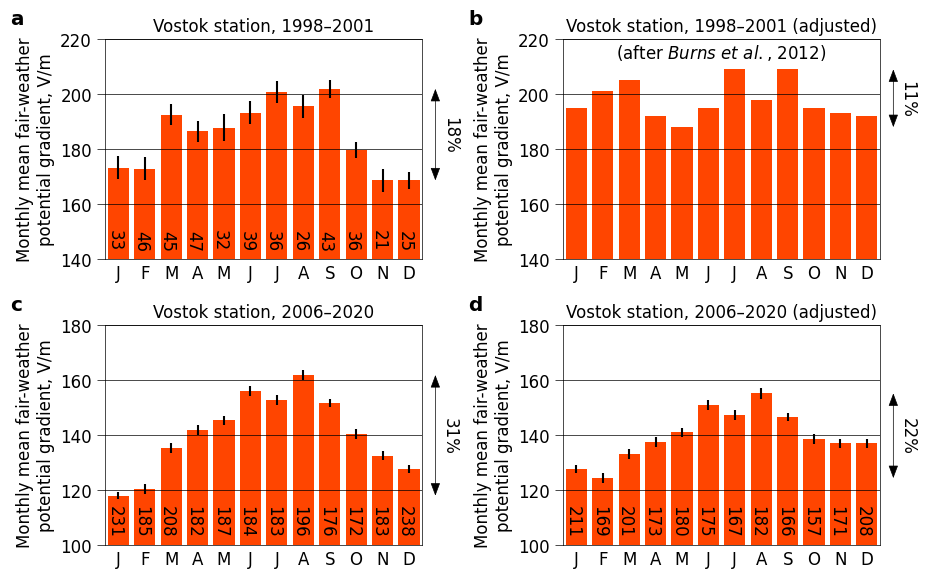

In [65]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(4)]

for n in range(4):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [140] * 2 + [100] * 2
high = [220] * 2 + [180] * 2
step = [20] * 4
coeff = [1] * 4

caption = ['Vostok station, 1998–2001',
           'Vostok station, 1998–2001 (adjusted)',
           'Vostok station, 2006–2020',
           'Vostok station, 2006–2020 (adjusted)']
col = ['orangered'] * 4

for n in range(4):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis='y')
    ax[n].tick_params(length=0, width=0.5, axis='x')
    ax[n].grid(color='0.', linewidth=0.5, axis='y')

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize='large', va='top')

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize='large')
    ax[n].set_ylabel('Monthly mean fair-weather\npotential gradient, V/m',
                     fontsize='large')

    ax[n].set_title(caption[n], fontsize='large')
    if np.sum(data_counter[n]) == 0:
        ax[n].text(0.5,
                   1 - 0.01
                   * (ax[n].get_position().x1 - ax[n].get_position().x0)
                   / (ax[n].get_position().y1 - ax[n].get_position().y0)
                   * fig.get_size_inches()[0] / fig.get_size_inches()[1],
                   '(after $\it{Burns~et~al.}$, 2012)',
                   fontsize='large', ha='center', va='top',
                   transform=ax[n].transAxes)

    ax[n].annotate('', xy=(12, np.min(data[n])), xycoords='data',
                   xytext=(12, np.max(data[n])), textcoords='data',
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle='<|-|>,head_length=0.8,head_width=0.3',
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle='arc3,rad=0.', fc='black',
                       linewidth=0.5
                   ))
    if np.sum(data_counter[n]) == 0:
        ampl = (np.max(data[n]) - np.min(data[n])) / np.mean(data[n])
    else:
        ampl = (np.max(data[n]) - np.min(data[n])) / \
            np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f'{ampl * 100:.0f}%',
               fontsize='large', ha='left', va='center', rotation=270)

fig.align_ylabels([ax[0], ax[2]])
fig.align_ylabels([ax[1], ax[3]])

for n in range(4):
    if np.sum(data_counter[n]) == 0:
        ax[n].bar(np.arange(12), data[n],
          width=0.8, color=col[n])
    else:
        ax[n].bar(np.arange(12), data[n],
                  yerr=std_error(data[n],
                                 data_sqr[n],
                                 data_counter[n]),
                  width=0.8, color=col[n])

for n in range(4):
    ax[n].text(-0.3, 1.05, chr(ord('a') + n), fontsize='x-large',
               fontweight='semibold', ha='left', va='bottom',
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(4):
    if np.sum(data_counter[n]) > 0:
        for m in range(12):
            ax[n].annotate(f'{data_counter[n, m]}',
                           xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                           rotation=270, ha='center', va='bottom',
                           fontsize='large', color='0.')

fig.savefig('figures_two_parts/pg_corrected.eps', bbox_inches='tight')